In [1]:
import pandas as pd
import numpy as np

import fix_yahoo_finance as yf
import matplotlib.pyplot as plt

spx = yf.download('^GSPC','2017-01-01','2017-12-31')
spx

ImportError: No module named 'fix_yahoo_finance'

In [ ]:
spx = yf.download('^GSPC','2017-01-01','2017-12-31')

In [2]:
'import Bloomberg file'
stocks = pd.read_excel('/Users/guoyangwan/Downloads/cpp_data_2.xlsx')

In [3]:
num_stocks = np.shape(stocks)[0] # number of stocks
Classify = []
for i in range(num_stocks):
    if stocks.loc[i,'Performance'] > 0.065:
        Classify.extend(['Beat'])
    elif stocks.loc[i,'Performance'] < 0:
        Classify.extend(['Miss'])
    else:
        Classify.extend(['Meet'])
# append Classify column to the stock DataFrame
stocks['Classify'] = Classify

In [4]:
print('Number of Beat: ',sum(1 for i in Classify if i=='Beat'))
print('Number of Meet: ',sum(1 for i in Classify if i=='Meet'))
print('Number of Miss: ',sum(1 for i in Classify if i=='Miss'))

Number of Beat:  149
Number of Meet:  209
Number of Miss:  101


In [5]:
'get yahoo data'
# get SPX data
spx = yf.download('^GSPC','2016-01-01','2018-04-30')

[*********************100%***********************]  1 of 1 downloaded

In [6]:
# to check the data downloaded
spx.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4664940000


<font color="red">**Note:**</font><br>
The output of the following code out of range, cannot be implemented in $Notebook$. This program is finished in $Spyder$ 

In [ ]:
# download stock data
Stock_Pool = []
Stock_Size = []
for i in range(num_stocks):
    ContData = yf.download(stocks.loc[i,'Ticker'],
                           stocks.loc[i,'StartDate'],
                           stocks.loc[i,'EndDate'])
    Stock_Pool.append([stocks.iloc[i,:],ContData ])
    Stock_Size.append(np.size(ContData))
    
    # check download process
    print(i)

In [ ]:
Group_Stocks = Stock_Pool        

'classify stock into different groups: Meet, Miss, Beat'
Beat = []
Meet = []
Miss = []
for i in range(num_stocks):
    if Group_Stocks[i][0]['Classify'] == 'Beat':
        Beat.append(Group_Stocks[i])
    elif Group_Stocks[i][0]['Classify'] == 'Meet':
        Meet.append(Group_Stocks[i])
    else:
        Miss.append(Group_Stocks[i])

'Build Classified_Pool to contain different groups'
Classified_Pool = []
Classified_Pool.append(Beat)
Classified_Pool.append(Meet)
Classified_Pool.append(Miss)


In [ ]:
'Calculate stock return, and the difference between SPX return'
num_groups = np.size(Classified_Pool) # number of groups, Miss, Beat, Meet

for i in range(num_groups):
    # number of stocks beat/ meet / miss expectation
    num_of_each_group = np.shape(Classified_Pool[i])[0]
    for j in range(num_of_each_group):
        ContVal = Classified_Pool[i][j][1]
        # ContVal.index: to get time
        # calculate stock return
        a = ContVal.loc[ContVal.index[1]:,'Adj Close']
        b = ContVal.loc[:ContVal.index[-2],'Adj Close']
        ret_stock = np.log(np.divide(a,b))
        
        # calculate SPX return
        spx_series = spx.loc[ContVal.index[0]:ContVal.index[-1],:]
        c = spx_series.loc[ContVal.index[1]:,'Adj Close']
        d = spx_series.loc[:ContVal.index[-2], 'Adj Close']
        ret_spx = np.log(np.divide(c,d))
        
        # calculate abnormal return
        ret_diff = ret_stock - ret_spx
        
        # calculate cumulative abnormal return
        ret_diff_cum = np.zeros(np.size(ret_diff))
        for k in range(np.size(ret_diff)):
            if k==0:
                ret_diff_cum[k] = ret_diff[k]
            else:
                ret_diff_cum[k] = ret_diff_cum[k-1] + ret_diff[k]
        
        Classified_Pool[i][j].append(ret_stock)
        Classified_Pool[i][j].append(ret_diff)


In [ ]:
'calculate average abnormal return and '
'cumulative average abnormal return'

AAR_group_bp = [] # AAR of each group with bootstrap
for i in range(num_groups):
    num_of_each_group = np.shape(Classified_Pool[i])[0]
    # bootstrap 30 times
    AAR = [] # AAR of 60 stocks
    for j in range(30): 
        # each time, select 60 stocks
        random_selected_stocks = np.random.randint(num_of_each_group,size = (1,60))
        
        AR = [] # abnormal return of 60 stocks
        for k in range(60):
            const = random_selected_stocks[0,k]
            AR.append(Classified_Pool[i][const][3])
        
        AR_average = np.mean(AR,axis=0)
        AAR.append(AR_average)
                    
    AAR_bp = np.mean(AAR, axis=0)
    AAR_bp = np.nan_to_num(AAR_bp)
    AAR_group_bp.append(AAR_bp)

        
CAAR_group_bp = [] # CAAR of each group with bootstrap
for i in range(num_groups):
    num_of_each_series = np.size(AAR_group_bp[i])
    ContSeries = np.zeros(num_of_each_series)
    for j in range(num_of_each_series):
        if j==0:
            ContSeries[j] = AAR_group_bp[i][j]
        else:
            ContSeries[j] = ContSeries[j-1] + AAR_group_bp[i][j]
    CAAR_group_bp.append(ContSeries)
 

In [ ]:
'CAAR'
plt.title('Cumulative Average Abnormal Return')
plt.xlabel('Day')
plt.ylabel('Return')
plt.plot(CAAR_group_bp[0], label='Beat')
plt.plot(CAAR_group_bp[1], label='Meet')
plt.plot(CAAR_group_bp[2], label='Miss')
plt.legend()
plt.show() 

After running the program, we get the following CAAR graph. Here is a sharp jump at day 62nd of group $Miss$, and we double here are something wrong. Finally we find that Welltower Inc company changed its ticker and the stock price got changed, causing the daily return extremly high. 
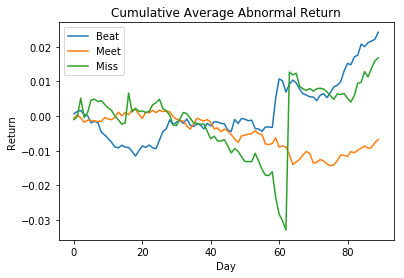
After removing this stock, we get the following CAAR graph.
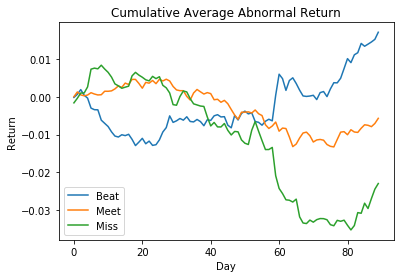

In [ ]:
'AAR'
plt.title('Average Abnormal Return')
plt.xlabel('Day')
plt.ylabel('Return')
plt.plot(AAR_group_bp[0], label='Beat')
plt.plot(AAR_group_bp[1], label='Meet')
plt.plot(AAR_group_bp[2], label='Miss')
plt.legend()
plt.show()

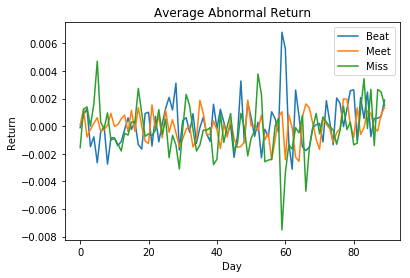